In [1]:
#using CUDA
using Test
using BenchmarkTools

using Plots
using LaTeXStrings
using Colors, ColorSchemes
cs1 = ColorScheme(range(colorant"red", colorant"royalblue1", length=5));

using QuadGK

using Base.Threads: @threads, @spawn
ENV["JULIA_NUM_THREADS"]

"64"

In [2]:
include("qts.jl")
include("brentq.jl")
include("fields.jl")

psi_s_case_E (generic function with 1 method)

In [3]:
gg(x) = sqrt(1-x)
QTS_will(gg, -3.5, 1.0)

6.363961030680568

In [4]:
g(x) = x^2-1
brentq(g, 0, 10)

1.0000000000002276

In [32]:
const rho = 1.5
gamma = 20000.0

beta = (1-1/gamma^2)^(1/2)
lamb = 0.01/rho

const phi_m = 0.5/rho

sigma_z = 50e-6
sigma_x = 50e-6

lamb_2d(z::Float64, x::Float64) = 1/(2*pi*sigma_x*sigma_z)* exp(-z^2 / 2 / sigma_z^2 - x^2 / 2 / sigma_x^2)
lamb_2d_dz(z::Float64, x::Float64) = -z/(2*pi*sigma_x*sigma_z^3)* exp(-z^2 / 2 / sigma_z^2 - x^2 / 2 / sigma_x^2)

lamb_2d_dz (generic function with 1 method)

In [6]:
alpha_exact_case_D_brentq( 0.001, 0.001, beta, lamb )

0.183921363133276

In [15]:
Es_case_D(0.0, 0.0, gamma, lamb)

5.0417237555250725e10

In [6]:
Es_case_B(1E-6, 1E-6, gamma)

1.8260910737535056e7

In [11]:
psi_s_case_E(1E-6, 1E-6, gamma)*(-1/gamma^2)

-0.039999999248339024

In [6]:
Es_case_E(0, 0, gamma)

NaN

# Case E

# 3 terms  
### $Ws_{integral}(zob, xob) = \int\int^{zob - znear}_{zob - zod} ws(zob-z', xob - x') \lambda_b'(z',x')dz'dx'$ ,

$zod = \rho (\lambda -\beta \sqrt{\lambda^2 + ((xob-x')/\rho)^2} )$ 

$znear = -\beta |xob - x'|$

#### $Ws_{boundary, far}(zob, xob) = \int ws(L=\rho\lambda, xob-x') \lambda_b(zob - zod, x') dx'$

#### $Ws_{boundary, near}(zob, xob) = -\int ws(L=0, xob-x') \lambda_b(zob - znear, x') dx'$

In [33]:
function compute_Ws_case_E_boundary(z_ob::Float64, x_ob::Float64, gamma::Float64, lamb::Float64)
    
    chi(xp::Float64) = ( x_ob - xp )/rho
    zod(xp::Float64)  = rho*(lamb - beta*sqrt(lamb^2 + chi(xp)^2))
    z_near(xp::Float64) = -beta*abs(x_ob - xp) 
    
    ## integral    
    #iii1(z::Float64) =  psi_s_case_E((z_ob-z), (x_ob-xp), gamma)*lamb_2d_dz(z,xp)
    
    L_far = rho*lamb
    psi_s_case_E_far(x::Float64) = 1/(sqrt(x^2 + L_far^2) - beta*L_far)
    psi_s_case_E_near(x::Float64) = 1/abs(x)
    
    
    iii2(xp::Float64) = psi_s_case_E_far( x_ob-xp )*lamb_2d(z_ob-zod(xp), xp)
    iii3(xp::Float64) = -psi_s_case_E_near( x_ob-xp )*lamb_2d(z_ob-z_near(xp), xp)
    
    
    ifar_1 = QTS_will(iii2, -5*sigma_x, x_ob)       
    ifar_2 = QTS_will(iii2, x_ob, 5*sigma_x)     
    
    #ifar = quadgk(xp -> iii2(xp), -5*sigma_x, 5*sigma_x,  rtol=1e-4)[1]
    
    inear_1 = QTS_will(iii3, -5*sigma_x, x_ob)       
    inear_2 = QTS_will(iii3, x_ob, 5*sigma_x)       
    
    #return (ifar_1 + ifar_2)*(-1.0/gamma^2)    
    #return (inear_1 + inear_2)*(-1.0/gamma^2)  
    return (ifar_1 + ifar_2 + inear_1 + inear_2)*(-1.0/gamma^2)  

end

compute_Ws_case_E_boundary (generic function with 1 method)

In [22]:
compute_Ws_case_E_boundary(0.0, 0.0, 5000.0, lamb)

-157302.6037214035

In [34]:
# using Roots 

function QTS_case_E(z_ob::Float64, x_ob::Float64, gamma::Float64, lamb::Float64, xp::Float64)
    
    ## integral    
    iii(z::Float64) = psi_s_case_E((z_ob-z), (x_ob-xp), gamma)*lamb_2d_dz(z,xp)
    #println("iii(1e-8)", iii(1e-8))
    
    ## boundary conditions
    chi = ( x_ob - xp )/rho
    zod = rho*(lamb - beta*sqrt(lamb^2 + chi^2))
    z_near = -beta*abs(x_ob - xp)

    #println("zod:", zod)
    #println("z_near:", z_near)

    # if z_near is too close to zero, the integral blows up
    if z_near > -1E-16
        z_near = -1E-16
    end
    
    i1 = QTS_will(iii, z_ob - zod, z_ob-1E-16)
    i2 = QTS_will(iii, z_ob + 1E-16, z_ob - z_near)
    #i2 = isapprox(0.0, z_near ; atol=1e-20) ? 0.0 : QTS_will(iii, z_ob, z_ob - z_near)        
    #println("i1", i1)
    #println("i2", i2)
    
   # z_near = isapprox(0.0, z_near ; atol=1e-20) ? 1E-20, 
    
    #i_all = QTS_will(iii, z_ob - zod, z_ob-z_near)
    
    return (i1+i2)
    
    #return i_all*(-1.0/gamma^2)

    
end 

QTS_case_E (generic function with 1 method)

In [6]:
QTS_case_E(5*sigma_z, 0.0, gamma, lamb, 0.0)

-3.8769468184952414e8

In [208]:
    sigma_x  = 50e-6 
    xp_max = 5*sigma_x 
    xp_min = -5*sigma_x  
    dxp = (xp_max - xp_min)/(101-1)

    xp_vec = xp_min:dxp:xp_max

-0.00025:5.0e-6:0.00025

In [169]:
xp_vec[51]

0.0

In [35]:
function compute_Ws_case_E_integral(z_ob::Float64, x_ob::Float64, gamma::Float64, phi::Float64, nxp::Int)
    sigma_x  = 50e-6 
    xp_max = 5*sigma_x 
    xp_min = -5*sigma_x  
    dxp = (xp_max - xp_min)/(nxp-1)

    xp_vec = xp_min:dxp:xp_max
    
    #qvec is for testing only
    qvec = similar(xp_vec)  
    
    sum = 0.0
    
    for i in 1:1:length(xp_vec)
        qvec[i] = QTS_case_E(z_ob, x_ob, gamma, phi, xp_vec[i])  # for testing
        #println("integral:", qvec[i])
        sum += QTS_case_E(z_ob, x_ob, gamma, phi, xp_vec[i])   # for CPU only  
    end
    
    #return qvec
    return sum* dxp*(-1.0/gamma^2)
end

compute_Ws_case_E_integral (generic function with 1 method)

In [10]:
compute_Ws_case_E_integral(0.0, 0.0, gamma, lamb, 101)

0.24873693761020962

In [11]:
compute_Ws_case_E_boundary(0.0, 0.0, gamma, lamb)

-19830.42912520345

In [36]:
function Ws_case_E_multithread_lamb(lamb; nz=31, nx=5)
    out = zeros(Float64, nz, nx)
    z_ob = range(-5*sigma_z, 5*sigma_z, length = nz)
    x_ob = range(-2*sigma_x, 2*sigma_x, length = nx)
    @sync for i in 1:nz
        @spawn for j in 1:nx
            out[i,j] = compute_Ws_case_E_boundary(z_ob[i], x_ob[j], gamma, lamb)
            #out[i,j] = compute_Ws_case_E_integral(z_ob[i], x_ob[j], gamma, lamb, 101)
            
            #out[i,j] = compute_Ws_case_E_integral(z_ob[i], x_ob[j], gamma, lamb, 101) + compute_Ws_case_E_boundary(z_ob[i], x_ob[j], gamma, lamb)
        end
    end
    return out
end

Ws_case_E_multithread_lamb (generic function with 1 method)

In [37]:
Ws_caseE_mat_lamb_001 = Ws_case_E_multithread_lamb(0.01, nz=101, nx=3);

In [38]:
Ws_caseE_mat_lamb_002 = Ws_case_E_multithread_lamb(0.02, nz=101, nx=3);

In [39]:
Ws_caseE_mat_lamb_003 = Ws_case_E_multithread_lamb(0.03, nz=101, nx=3);

In [40]:
Ws_caseE_mat_lamb_005 = Ws_case_E_multithread_lamb(0.05, nz=101, nx=3);

In [41]:
Ws_caseE_mat_lamb_008 = Ws_case_E_multithread_lamb(0.08, nz=101, nx=3);

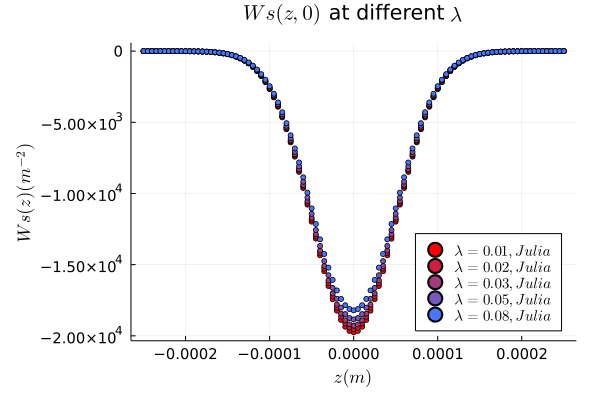

In [42]:
z_ob = range(-5*sigma_z, 5*sigma_z, length = 101)
plot(z_ob, Ws_caseE_mat_lamb_001[102:202], linewidth=2, label=L"\lambda =0.01, Julia", markersize = 3, seriestype = :scatter, color=cs1[1])
plot!(z_ob, Ws_caseE_mat_lamb_002[102:202], linewidth=2, label=L"\lambda =0.02, Julia", markersize = 3, seriestype = :scatter, color=cs1[2])
plot!(z_ob, Ws_caseE_mat_lamb_003[102:202], linewidth=2, label=L"\lambda =0.03, Julia", markersize = 3, seriestype = :scatter, color=cs1[3])
plot!(z_ob, Ws_caseE_mat_lamb_005[102:202], linewidth=2, label=L"\lambda =0.05, Julia", markersize = 3, seriestype = :scatter, color=cs1[4])
plot!(z_ob, Ws_caseE_mat_lamb_008[102:202], linewidth=2, label=L"\lambda =0.08, Julia", markersize = 3, seriestype = :scatter, color=cs1[5])


plot!(xlabel=L"$z (m)", ylabel=L"$Ws(z) (m^{-2})$", title=L"$Ws(z,0)$ at different $\lambda$")
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), margin=4Plots.mm, legend=:bottomright, legendfontsize = 10)

# Case D

In [44]:
using Roots 

function QTS_case_D(z_ob::Float64, x_ob::Float64, gamma::Float64, lamb::Float64, xp::Float64)
    
    ## integral    
    iii(z::Float64) =  Es_case_D((z_ob-z)/2.0/rho, (x_ob-xp)/rho, gamma, lamb)*lamb_2d(z,xp)
    
    #println("iii(1e-8)", iii(1e-8))
    
    ## boundary conditions
    chi = ( x_ob - xp )/rho
    zid = rho*(phi_m + lamb - beta*sqrt(lamb^2 + chi^2 + 4*(1 + chi)*sin(phi_m/2)^2 + 2*lamb*sin(phi_m)))
    zod = rho*(lamb - beta*sqrt(lamb^2 + chi^2))
    
    #println("xp: ", xp)
    #println("zid: ", zid)
    #println("zod: ", zod)
    
#####################################
    # find critical alpha

    # These came from Es_case_D
    #N1(alp::Float64) = cos(2*alp) - (1+chi)
    kap(alp::Float64) = sqrt(lamb^2 + chi^2 + 4*(1+chi)*sin(alp)^2 + 2*lamb*sin(2*alp))
    N2(alp::Float64) = lamb*cos(2*alp) + (1+chi)*sin(2*alp) - beta * kap(alp)

    #println("N2(1e-9): ", N2(1E-9))
    
    alp_crit2_found = true
    
    alp_crit2 = try find_zero(N2, 0)
    catch 
        alp_crit2_found = false
    end

    #println("alp_crit2: ", alp_crit2)
    
    alp_crit2_usable = false

    if alp_crit2_found == true
        z_crit2  = z_ob - 2*rho*(alp_crit2 + (lamb - beta*kap(alp_crit2))/2)  
        if (z_crit2 > z_ob - zid) && (z_crit2 < z_ob - zod)
            alp_crit2_usable = true
        end
    end        
    
    # TESTING
    if (alp_crit2_usable == true)
        #println("ONLY USING N2 BP!!!")
        
        zp1 = z_crit2
        i1 = QTS_will(iii, z_ob - zid, zp1)
        i2 = QTS_will(iii, zp1, z_ob - zod)        
        return i1+i2
        
        
        #println("split BP :", z_crit2)
        zp1 = z_crit2 - 2E-10
        zp2 = z_crit2
        zp3 = z_crit2 + 2E-10
        
        #i1 = QTS_will(iii, z_ob - zid, zp1)
        #i2 = QTS_will(iii, zp1, zp2)    
        #i3 = QTS_will(iii, zp2, zp3) 
        #i4 = QTS_will(iii, zp3, z_ob - zod) 
        
        
        i1 = quadgk(z -> iii(z), z_ob - zid, zp1,  rtol=1e-4)[1]
        i2 = quadgk(z -> iii(z), zp1, zp2, rtol=1e-4)[1]
        i3 = quadgk(z -> iii(z), zp2, zp3, rtol=1e-4)[1]
        i4 = quadgk(z -> iii(z), zp3, z_ob - zod, rtol=1e-4)[1]

        return i1+i2+i3+i4
        
    else
        #println("USING NO BP!!!")
        return QTS_will(iii, z_ob - zid, z_ob - zod)
    end
    
end 

QTS_case_D (generic function with 1 method)

In [27]:
QTS_case_D(0.0, 0.0, gamma, 0.0, 0.0)

-4.1357821799112988e9

In [45]:
function compute_Ws_case_D(z_ob::Float64, x_ob::Float64, gamma::Float64, lamb::Float64, nxp::Int)
    sigma_x  = 50e-6 
    xp_max = 5*sigma_x 
    xp_min = -5*sigma_x  
    dxp = (xp_max - xp_min)/(nxp-1)

    xp_vec = xp_min:dxp:xp_max
    
    #qvec is for testing only
    qvec = similar(xp_vec)  
    
    sum = 0.0
    
    for i in 1:1:length(xp_vec)
        #qvec[i] = QTS_case_D(z_ob, x_ob, gamma, lamb, xp_vec[i])   # for testing
        sum += QTS_case_D(z_ob, x_ob, gamma, lamb, xp_vec[i])   # for CPU only

    end
    
    #return qvec
    return sum* dxp*beta^2/rho^2
end

compute_Ws_case_D (generic function with 1 method)

In [21]:
compute_Ws_case_D(0.0, 0.0, gamma, lamb, 101)

-103200.29301776778

In [46]:
function Ws_case_D_multithread_lamb(lamb; nz=31, nx=5)
    out = zeros(Float64, nz, nx)
    z_ob = range(-5*sigma_z, 5*sigma_z, length = nz)
    x_ob = range(-2*sigma_x, 2*sigma_x, length = nx)
    @sync for i in 1:nz
        @spawn for j in 1:nx
            out[i,j] = compute_Ws_case_D(z_ob[i], x_ob[j], gamma, lamb, 101)
        end
    end
    return out
end

Ws_case_D_multithread_lamb (generic function with 1 method)

In [152]:
# when lamb is zero, case D can behave badly
Ws_caseD_mat_lamb_0 = Ws_case_D_multithread_lamb(0.0/rho, nz=101, nx=3);

In [64]:
@btime Ws_caseD_mat_lamb_001 = Ws_case_D_multithread_lamb(lamb, nz=101, nx=5);

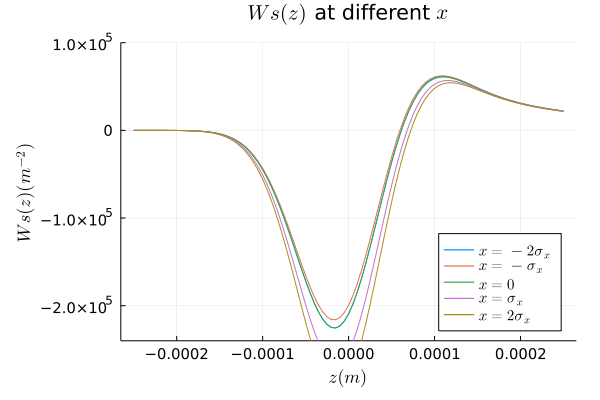

In [65]:
z_ob = range(-5*sigma_z, 5*sigma_z, length = 101)

plot(z_ob, Ws_caseD_mat_lamb_001[1:101], label=L"x =-2\sigma_x")
plot!(z_ob, Ws_caseD_mat_lamb_001[102:202], label=L"x = -\sigma_x")
plot!(z_ob, Ws_caseD_mat_lamb_001[203:303], label=L"x = 0")
plot!(z_ob, Ws_caseD_mat_lamb_001[304:404], label=L"x = \sigma_x")
plot!(z_ob, Ws_caseD_mat_lamb_001[405:505], label=L"x =2\sigma_x")

#plot!(z_ob, Ws_caseD_mat[5051:5151], label=L"x = 0")
#
#plot!(z_ob, Ws_caseD_mat[6061:6161], label=L"x =\sigma_x")

plot!(xlabel=L"$z (m)", ylabel=L"$Ws(z) (m^{-2})$", title=L"$Ws(z)$ at different $x$", ylims=(-2.4e5, 1e5))
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), margin=4Plots.mm, legend=:bottomright, legendfontsize = 10)


In [47]:
Ws_caseD_mat_lamb_001 = Ws_case_D_multithread_lamb(0.01, nz=101, nx=3);

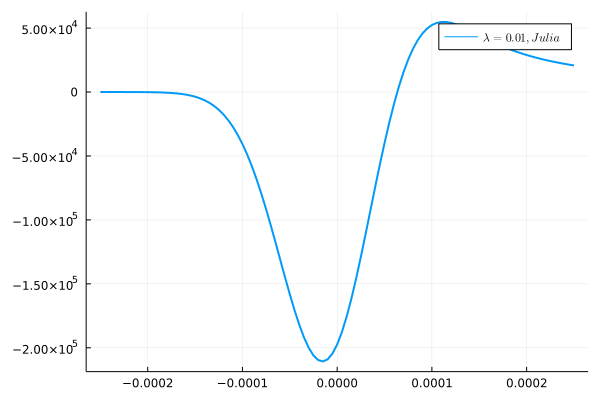

In [48]:
plot(z_ob, Ws_caseD_mat_lamb_001[102:202]+ Ws_caseE_mat_lamb_001[102:202], linewidth=2, label=L"\lambda =0.01, Julia")

In [49]:
Ws_caseD_mat_lamb_002 = Ws_case_D_multithread_lamb(0.02, nz=101, nx=3);

In [50]:
Ws_caseD_mat_lamb_003 = Ws_case_D_multithread_lamb(0.03, nz=101, nx=3);

In [51]:
Ws_caseD_mat_lamb_005 = Ws_case_D_multithread_lamb(0.05, nz=101, nx=3);

In [52]:
Ws_caseD_mat_lamb_008 = Ws_case_D_multithread_lamb(0.08, nz=101, nx=3);

In [ ]:
, label=L"\phi=0.04, Julia", markersize = 3, seriestype = :scatter, color=cs1[1]

In [169]:
Ws_caseD_mat_lamb_001[102:202] + Ws_caseE_mat_lamb_001[102:202];

In [35]:
gamma

10000.0

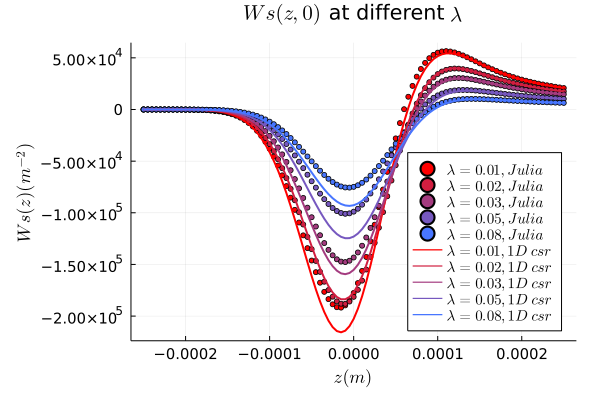

In [61]:
z_ob = range(-5*sigma_z, 5*sigma_z, length = 101)
#plot(z_ob, Ws_caseD_mat_lamb_0001[1:101], linewidth=2, label=L"\lambda =0.001")
plot(z_ob, Ws_caseD_mat_lamb_001[102:202], linewidth=2, label=L"\lambda =0.01, Julia", markersize = 3, seriestype = :scatter, color=cs1[1])
plot!(z_ob, Ws_caseD_mat_lamb_002[102:202], linewidth=2, label=L"\lambda =0.02, Julia", markersize = 3, seriestype = :scatter, color=cs1[2])
plot!(z_ob, Ws_caseD_mat_lamb_003[102:202], linewidth=2, label=L"\lambda =0.03, Julia", markersize = 3, seriestype = :scatter, color=cs1[3])
plot!(z_ob, Ws_caseD_mat_lamb_005[102:202], linewidth=2, label=L"\lambda =0.05, Julia", markersize = 3, seriestype = :scatter, color=cs1[4])
plot!(z_ob, Ws_caseD_mat_lamb_008[102:202], linewidth=2, label=L"\lambda =0.08, Julia", markersize = 3, seriestype = :scatter, color=cs1[5])

plot!(z_ob, WsD_1D_vec_1, linewidth=2, label=L"\lambda =0.01, 1D~csr", color=cs1[1])
plot!(z_ob, WsD_1D_vec_2, linewidth=2, label=L"\lambda =0.02, 1D~csr", color=cs1[2])
plot!(z_ob, WsD_1D_vec_3, linewidth=2, label=L"\lambda =0.03, 1D~csr", color=cs1[3])
plot!(z_ob, WsD_1D_vec_4, linewidth=2, label=L"\lambda =0.05, 1D~csr", color=cs1[4])
plot!(z_ob, WsD_1D_vec_5, linewidth=2, label=L"\lambda =0.08, 1D~csr", color=cs1[5])


plot!(xlabel=L"$z (m)", ylabel=L"$Ws(z) (m^{-2})$", title=L"$Ws(z,0)$ at different $\lambda$")
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), margin=4Plots.mm, legend=:bottomright, legendfontsize = 10)

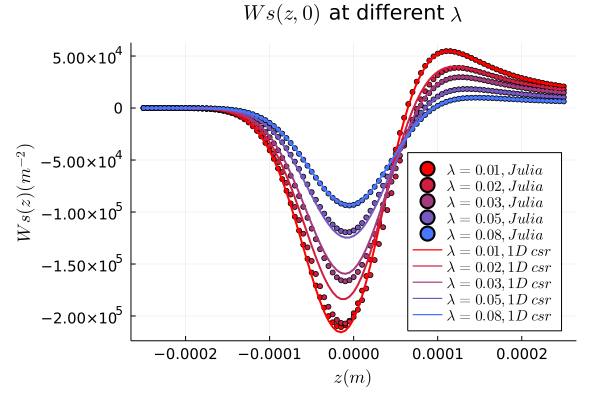

In [62]:
z_ob = range(-5*sigma_z, 5*sigma_z, length = 101)
#plot(z_ob, Ws_caseD_mat_lamb_0001[1:101], linewidth=2, label=L"\lambda =0.001")
plot(z_ob, Ws_caseD_mat_lamb_001[102:202] +Ws_caseE_mat_lamb_001[102:202], linewidth=2, label=L"\lambda =0.01, Julia", markersize = 3, seriestype = :scatter, color=cs1[1])
plot!(z_ob, Ws_caseD_mat_lamb_002[102:202] +Ws_caseE_mat_lamb_002[102:202], linewidth=2, label=L"\lambda =0.02, Julia", markersize = 3, seriestype = :scatter, color=cs1[2])
plot!(z_ob, Ws_caseD_mat_lamb_003[102:202]+Ws_caseE_mat_lamb_003[102:202], linewidth=2, label=L"\lambda =0.03, Julia", markersize = 3, seriestype = :scatter, color=cs1[3])
plot!(z_ob, Ws_caseD_mat_lamb_005[102:202]+Ws_caseE_mat_lamb_005[102:202], linewidth=2, label=L"\lambda =0.05, Julia", markersize = 3, seriestype = :scatter, color=cs1[4])
plot!(z_ob, Ws_caseD_mat_lamb_008[102:202]+Ws_caseE_mat_lamb_008[102:202], linewidth=2, label=L"\lambda =0.08, Julia", markersize = 3, seriestype = :scatter, color=cs1[5])

plot!(z_ob, WsD_1D_vec_1, linewidth=2, label=L"\lambda =0.01, 1D~csr", color=cs1[1])
plot!(z_ob, WsD_1D_vec_2, linewidth=2, label=L"\lambda =0.02, 1D~csr", color=cs1[2])
plot!(z_ob, WsD_1D_vec_3, linewidth=2, label=L"\lambda =0.03, 1D~csr", color=cs1[3])
plot!(z_ob, WsD_1D_vec_4, linewidth=2, label=L"\lambda =0.05, 1D~csr", color=cs1[4])
plot!(z_ob, WsD_1D_vec_5, linewidth=2, label=L"\lambda =0.08, 1D~csr", color=cs1[5])


plot!(xlabel=L"$z (m)", ylabel=L"$Ws(z) (m^{-2})$", title=L"$Ws(z,0)$ at different $\lambda$")
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), margin=4Plots.mm, legend=:bottomright, legendfontsize = 10)

# Case B

In [ ]:
julia> using Peaks

julia> t = 0:1/100:1;

julia> y = 2*sin.(5*t)+3*sin.(10*t)+2*sin.(30*t);

julia> pks, vals = findmaxima(y)
([8, 26, 48, 70, 88], [4.344867409921723, 5.5693856245725195, 0.42179571038522123, 3.050541716751975,
1.765468536605815])

julia> pks, proms = peakproms(pks, y)
([8, 26, 48, 70, 88], [1.9441651653930858, 5.5693856245725195, 2.203426259167901, 6.0957723300230855,
2.195991801053836])

julia> pks, widths, leftedge, rightedge = peakwidths(pks, y, proms)

In [59]:
Es_case_B(1e-9,0.0,gamma)

1.8343200402971927e11

In [284]:
nz = 2001    
z_max = 0.01*sigma_z
z_min = -0.01*sigma_z  

z_max = 2E-7
z_min = -2E-7
dz = (z_max - z_min)/(nz-1)

z_vec = z_min:dz:z_max

-2.0e-7:1.9999999999999998e-10:2.0e-7

In [310]:
Es_case_B_z(z) = Es_case_B(z, -5e-5 ,gamma)

Es_case_B_z (generic function with 1 method)

In [311]:
kaka = map(Es_case_B_z, z_vec);

In [312]:
pks, vals = findmaxima(kaka)

(Int64[], Float64[])

In [313]:
pks, proms = peakproms(pks, kaka)

(Int64[], Float64[])

In [314]:
pks, widths, leftedge, rightedge = peakwidths(pks, kaka, proms)

LoadError: BoundsError: attempt to access 0-element Vector{Int64} at index [1]

In [209]:
using Peaks

In [63]:
using Roots 

function QTS_case_B(z_ob::Float64, x_ob::Float64, gamma::Float64, phi::Float64, xp::Float64)
    
    ## integral    
    iii(z::Float64) =  Es_case_B((z_ob-z)/2.0/rho, (x_ob-xp)/rho, gamma)*lamb_2d(z,xp)
    
    #println("iii(1e-8)", iii(1e-8))
    
    ## boundary conditions
    chi = ( x_ob - xp )/rho
    zi = rho*(phi - beta*sqrt(chi^2 + 4*(1 + chi)*sin(phi/2)^2))
    zo = -beta*abs(x_ob - xp)

    
    
    #zp1 = 0.0
    #i1 = QTS_will(iii, z_ob - zid, zp1)
    #i2 = QTS_will(iii, zp1, z_ob - zod)        
    #return i1+i2

    #println("xp: ", xp)
    println("zi: ", zi)
    println("zo: ", zo)
    
#####################################
    # find critical alpha

    # These came from Es_case_B
    #N1(alp::Float64) = cos(2*alp) - (1+chi)
    kap(alp::Float64) = sqrt(chi^2 + 4*(1+chi)*sin(alp)^2)
    N2(alp::Float64) = (1+chi)*sin(2*alp) - beta*kap(alp)
    
    println("N2(1e-9): ", N2(1E-9))
    
    D(alp::Float64) = kap(alp) - beta*(1+chi)*sin(2*alp)

    alp_crit2_found = true
    
    #alp_crit2 = try find_zero(D, 0)
    alp_crit2 = try find_zero(N2, 0)
    catch 
        alp_crit2_found = false
    end

    println("alp_crit2: ", alp_crit2)
    
    alp_crit2_usable = false

    if alp_crit2_found == true
        z_crit2  = z_ob - 2*rho*(alp_crit2 - beta*kap(alp_crit2)/2)  
        if (z_crit2 > z_ob - zi) && (z_crit2 < z_ob - zo)
            alp_crit2_usable = true
        end
    end        
        
    
    # TESTING
    if (alp_crit2_usable == true)
        #println("ONLY USING N2 BP :", z_crit2)
        #zp1 = z_crit2
        #zp1 = 0.0
        
        #i1 = QTS_will(iii, z_ob - zi, zp1)
        #i2 = QTS_will(iii, zp1, z_ob - zo)    
        
        #i1 = quadgk(z -> iii(z), z_ob - zi, zp1, rtol=1e-4)[1]
        #i2 = quadgk(z -> iii(z), zp1, z_ob - zo, rtol=1e-4)[1]
        
        #return i1+i2
        
        #println("split BP :", z_crit2)
        zp1 = z_crit2 - 2E-10
        zp2 = z_crit2
        zp3 = z_crit2 + 2E-10
        
        #i1 = QTS_will(iii, z_ob - zi, zp1)
        #i2 = QTS_will(iii, zp1, zp2)    
        #i3 = QTS_will(iii, zp2, zp3) 
        #i4 = QTS_will(iii, zp3, z_ob - zo) 
        
        
        i1 = quadgk(z -> iii(z), z_ob - zi, zp1,  rtol=1e-4)[1]
        i2 = quadgk(z -> iii(z), zp1, zp2, rtol=1e-4)[1]
        i3 = quadgk(z -> iii(z), zp2, zp3, rtol=1e-4)[1]
        i4 = quadgk(z -> iii(z), zp3, z_ob - zo, rtol=1e-4)[1]

        return i1+i2+i3+i4
        
    else
        #println("USING NO BP!!!")
        
        zp1 = 0.0
        
        #i1 = QTS_will(iii, z_ob - zi, zp1)
        #i2 = QTS_will(iii, zp1, z_ob - zo)    
        
        return quadgk(z -> iii(z), z_ob - zi, z_ob - zo, rtol=1e-4)[1]
        
        #i1 = quadgk(z -> iii(z), z_ob - zi, zp1, rtol=1e-4)[1]
        #i2 = quadgk(z -> iii(z), zp1, z_ob - zo, rtol=1e-4)[1]
        
        #return i1+i2
        #return QTS_will(iii, z_ob - zi, z_ob - zo)
    end
    
end 

QTS_case_B (generic function with 1 method)

In [64]:
QTS_case_B(0.0, 0.0, gamma, phi_m, 0.0)

zi: 0.0023116025418654373
zo: -0.0
N2(1e-9): 2.4999999594378976e-18
alp_crit2: 0.0


-3.7929067721735964e9

In [271]:
QTS_case_B(0.0, 5e-5, gamma, 0.01, -2e-6)

zo: -5.1999998959999995e-5


-1.2250289256556421e11

In [570]:
QTS_case_B(0.0, 0.0, gamma, 0.01, -2e-6)

-3.9241544871026764e10

In [583]:
function compute_Ws_case_B(z_ob::Float64, x_ob::Float64, gamma::Float64, phi::Float64, nxp::Int)
    sigma_x  = 50e-6 
    xp_max = 5*sigma_x 
    xp_min = -5*sigma_x  
    dxp = (xp_max - xp_min)/(nxp-1)

    xp_vec = xp_min:dxp:xp_max
    
    #for testing only
    qvec = similar(xp_vec)  
    
    sum = 0.0
    
    for i in 1:1:length(xp_vec)
        qvec[i] = QTS_case_B(z_ob, x_ob, gamma, phi, xp_vec[i])  # for testing
        #println("integral:", qvec[i])
        #sum += QTS_case_B(z_ob, x_ob, gamma, phi, xp_vec[i])   # for CPU only
        
        
        #sum += QTS4(z_ob, x_ob, xp_vec[i])   # for CPU only
        
        # sum += QTS2(z_ob, x_ob, xp_vec[i])
        #sum +=1.0
    end
    
    return qvec
    #return sum* dxp*beta^2/rho^2
end

compute_Ws_case_B (generic function with 1 method)

In [21]:
#lalaB = compute_Ws_case_B(0.0, 0.0, gamma, phi_m, 101);

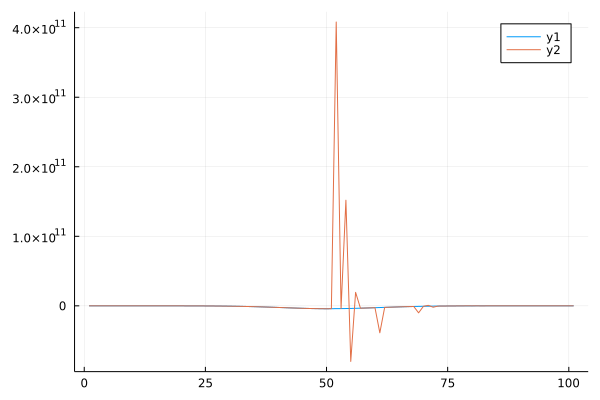

In [608]:
plot(lalaB)
plot!(lalaD)

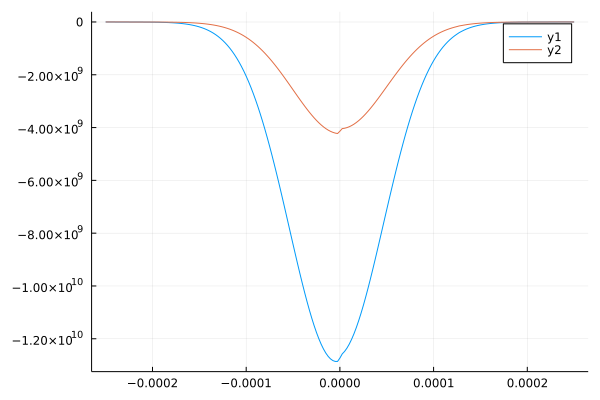

In [336]:
plot(xp_vec, test003)
plot!(xp_vec, test012)

In [339]:
test012 = compute_Ws_case_B(0.0, 0.0, gamma, 1.5, 201);

In [113]:
nxp = 201    
sigma_x  = 50e-6 
    xp_max = 5*sigma_x 
    xp_min = -5*sigma_x  
    dxp = (xp_max - xp_min)/(nxp-1)

    xp_vec = xp_min:dxp:xp_max

-0.00025:2.5e-6:0.00025

In [344]:
compute_Ws_case_B(0.0, 0.0, gamma, 0.03, 101)

-713116.5664122062

In [345]:
function Ws_case_B_multithread_phi(phi; nz=31, nx=5)
    out = zeros(Float64, nz, nx)
    z_ob = range(-5*sigma_z, 5*sigma_z, length = nz)
    x_ob = range(-2*sigma_x, 2*sigma_x, length = nx)
    @sync for i in 1:nz
        @spawn for j in 1:nx
            out[i,j] = compute_Ws_case_B(z_ob[i], x_ob[j], gamma, phi, 101)
        end
    end
    return out
end

Ws_case_B_multithread_phi (generic function with 1 method)

In [ ]:
phi_vec = [0.04, 0.06, 0.08, 0.1, 0.2];

In [370]:
Ws_caseB_mat_phi_004_2 = Ws_case_B_multithread_phi(0.04, nz=101, nx=3);

In [480]:
Ws_caseB_mat_phi_006_2 = Ws_case_B_multithread_phi(0.06, nz=101, nx=3);

In [371]:
Ws_caseB_mat_phi_008_2 = Ws_case_B_multithread_phi(0.08, nz=101, nx=3);

In [481]:
Ws_caseB_mat_phi_012_2 = Ws_case_B_multithread_phi(0.12, nz=101, nx=3);

In [470]:
Ws_caseB_mat_phi_02_2 = Ws_case_B_multithread_phi(0.1, nz=101, nx=3);

In [346]:
Ws_caseB_mat_phi_004 = Ws_case_B_multithread_phi(0.04, nz=101, nx=3);

In [392]:
Ws_caseB_mat_phi_006 = Ws_case_B_multithread_phi(0.06, nz=101, nx=3);

In [350]:
Ws_caseB_mat_phi_008 = Ws_case_B_multithread_phi(0.08, nz=101, nx=3);

In [378]:
Ws_caseB_mat_phi_012 = Ws_case_B_multithread_phi(0.12, nz=101, nx=3);

In [422]:
Ws_caseB_mat_phi_02 = Ws_case_B_multithread_phi(0.2, nz=101, nx=3);

In [572]:
Ws_caseB_mat_phi_03 = Ws_case_B_multithread_phi(0.3, nz=101, nx=3);

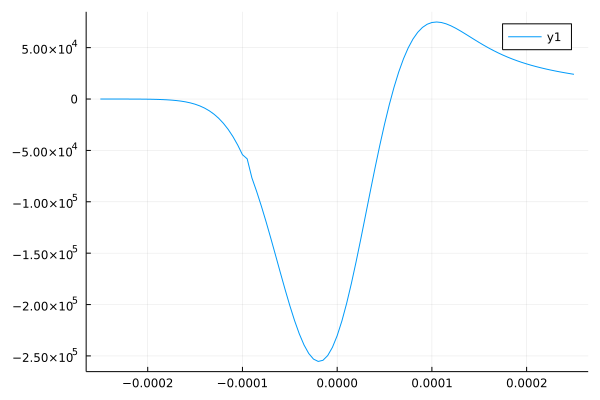

In [573]:
plot(z_ob, Ws_caseB_mat_phi_03[102:202])

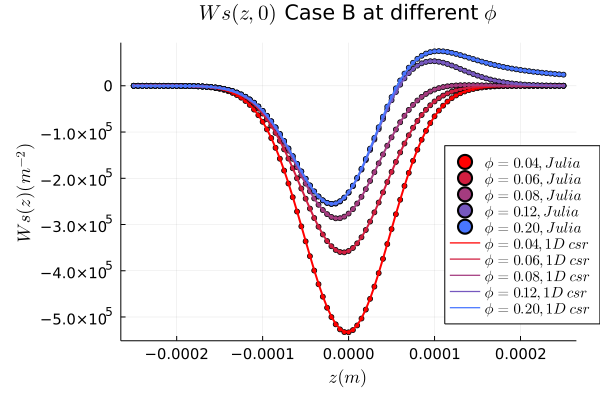

In [524]:
z_ob = range(-5*sigma_z, 5*sigma_z, length = 101)
plot(z_ob, Ws_caseB_mat_phi_004[102:202], label=L"\phi=0.04, Julia", markersize = 3, seriestype = :scatter, color=cs1[1])
plot!(z_ob, Ws_caseB_mat_phi_006[102:202], label=L"\phi=0.06, Julia", markersize = 3, seriestype = :scatter, color=cs1[2])
plot!(z_ob, Ws_caseB_mat_phi_008[102:202], label=L"\phi=0.08, Julia", markersize = 3, seriestype = :scatter, color=cs1[3])
plot!(z_ob, Ws_caseB_mat_phi_012[102:202], label=L"\phi=0.12, Julia", markersize = 3, seriestype = :scatter, color=cs1[4])
plot!(z_ob, Ws_caseB_mat_phi_02[102:202], label=L"\phi=0.20, Julia", markersize = 3, seriestype = :scatter, color=cs1[5])

plot!(z_ob, WsB_int_vec_1, linewidth=2, label=L"\phi=0.04, 1D~ csr", color=cs1[1])
plot!(z_ob, WsB_int_vec_2, linewidth=2, label=L"\phi=0.06, 1D~ csr", color=cs1[2])
plot!(z_ob, WsB_int_vec_3, linewidth=2, label=L"\phi=0.08, 1D~ csr", color=cs1[3])
plot!(z_ob, WsB_int_vec_4, linewidth=2, label=L"\phi=0.12, 1D~ csr", color=cs1[4])
plot!(z_ob, WsB_int_vec_5, linewidth=2, label=L"\phi=0.20, 1D~ csr", color=cs1[5])

plot!(xlabel=L"$z (m)", ylabel=L"$Ws(z) (m^{-2})$", title=L"$Ws(z,0)$ Case B at different $\phi$")
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), margin=4Plots.mm, legend=(0.8, 0.6), legendfontsize = 10)

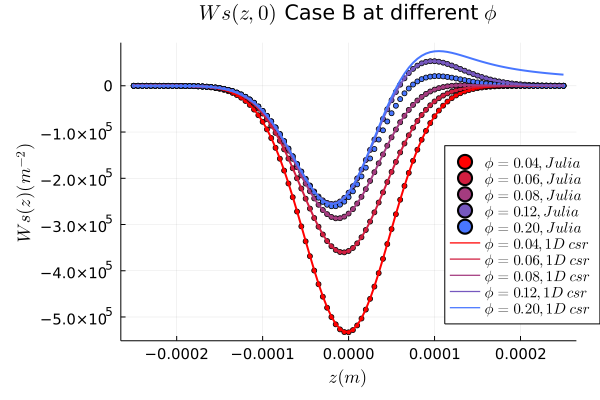

In [523]:
z_ob = range(-5*sigma_z, 5*sigma_z, length = 101)
plot(z_ob, Ws_caseB_mat_phi_004_2[102:202], label=L"\phi=0.04, Julia", markersize = 3, seriestype = :scatter, color=cs1[1])
plot!(z_ob, Ws_caseB_mat_phi_006_2[102:202], label=L"\phi=0.06, Julia", markersize = 3, seriestype = :scatter, color=cs1[2])
plot!(z_ob, Ws_caseB_mat_phi_008_2[102:202], label=L"\phi=0.08, Julia", markersize = 3, seriestype = :scatter, color=cs1[3])
plot!(z_ob, Ws_caseB_mat_phi_012_2[102:202], label=L"\phi=0.12, Julia", markersize = 3, seriestype = :scatter, color=cs1[4])
plot!(z_ob, Ws_caseB_mat_phi_02_2[102:202], label=L"\phi=0.20, Julia", markersize = 3, seriestype = :scatter, color=cs1[5])

plot!(z_ob, WsB_int_vec_1, linewidth=2, label=L"\phi=0.04, 1D~ csr", color=cs1[1])
plot!(z_ob, WsB_int_vec_2, linewidth=2, label=L"\phi=0.06, 1D~ csr", color=cs1[2])
plot!(z_ob, WsB_int_vec_3, linewidth=2, label=L"\phi=0.08, 1D~ csr", color=cs1[3])
plot!(z_ob, WsB_int_vec_4, linewidth=2, label=L"\phi=0.12, 1D~ csr", color=cs1[4])
plot!(z_ob, WsB_int_vec_5, linewidth=2, label=L"\phi=0.20, 1D~ csr", color=cs1[5])

plot!(xlabel=L"$z (m)", ylabel=L"$Ws(z) (m^{-2})$", title=L"$Ws(z,0)$ Case B at different $\phi$")
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), margin=4Plots.mm, legend=(0.8, 0.6), legendfontsize = 10)

# 1D THEORY

In [54]:
using QuadGK

lamb_1d(z::Float64) = 1/(sigma_z*sqrt(2*pi))* exp(-z^2 / 2 / sigma_z^2)
lamb_1d_prime(z::Float64) = 1/(sigma_z*sqrt(2*pi))* exp(-z^2 / 2 / sigma_z^2) * (-z / sigma_z^2)

z_L(phi::Float64) = rho*phi^3/24
coeff = -2/(3*rho^2)^(1/3)


# Case B boundary term ( for large phi this vanishes )
function Ws_case_B_1D_theory_boundary_term(z_ob::Float64, phi::Float64)
    #alternative form
    #return -4/phi/rho * lamb_1d( z_ob - rho*phi^3/24 )
    zL =  z_L(phi)
    return coeff* lamb_1d( z_ob - zL ) / zL^(1/3)
end



# Case B integral term ( for large phi this becomes the s-s wake )
function Ws_case_B_1D_theory_integral_term(z_ob::Float64, phi::Float64)
    w_ss(zp) = lamb_1d_prime(zp)/(z_ob - zp)^(1/3)
    return coeff*quadgk(w_ss, z_ob - z_L(phi), z_ob)[1]
end

# Case B Wx
function Wx_case_B_1D_theory(z_ob::Float64, phi::Float64)
    #alternative form
    return -4/rho * lamb_1d( z_ob )
end


# Case D boundary term ( for large phi_m this vanishes )
function Ws_case_D_1D_theory_boundary_term(z_ob::Float64, lamb::Float64, phi_m::Float64)
    x =  lamb*rho
    Lm = phi_m*rho   
    delta_s(l) =  l^3/24/rho^2*(l + 4*x)/(l + x)
    
    return - 4 * lamb_1d(z_ob - delta_s(Lm))/(Lm + 2*x)
end

# Case D integral term
# Check Dave Sagan's paper for the change-of-variable version of the integral 
function Ws_case_D_1D_theory_integral_term(z_ob::Float64, lamb::Float64, phi_m::Float64)
    x =  lamb*rho
    Lm = phi_m*rho     
    delta_s(l) =  l^3/24/rho^2*(l + 4*x)/(l + x)
    delta_s_prime(l) = l^2/8/rho^2*(l + 2*x)^2/(l + x)^2  
    ii(l) =  - 4/(l+2*x)* lamb_1d_prime(z_ob-delta_s(l))*delta_s_prime(l)
    
    return quadgk( ii, 0, Lm )[1]
end

Ws_case_D_1D_theory_integral_term (generic function with 1 method)

In [648]:
rho

1.5

In [55]:
# Check Dave Sagan's paper ofr the change-of-variable version of the integral 
def get_Wtot_D(zob):
    
    # x here is the exit distance
    x =  lamb*rho
    Lm = phi_m*rho
    def delta_s(l):
        return l**3/24/rho**2*(l + 4*x)/(l + x)
    def delta_s_prime(l):
        return l**2/8/rho**2*(l + 2*x)**2/(l + x)**2
    t1 = - 4 * lamb_1d(zob - delta_s(Lm))/(Lm + 2*x)
    def integrand(l):
        return 4/(l+2*x)* lamb_1d_prime(zob-delta_s(l))*delta_s_prime(l)
    t2 = - integrate.quad( integrand, 0, Lm)[0] 

    return t1 + t2

LoadError: syntax: extra token "get_Wtot_D" after end of expression

-0.00025:5.0e-6:0.00025

In [620]:
Ws_case_D_1D_theory_boundary_term(0.0, 0.0, phi_m)

-0.0

In [513]:
lamb_temp = 0.01

0.01

In [57]:
phi = 0.01
WsB_1D(z_ob::Float64) = Ws_case_B_1D_theory_boundary_term(z_ob, phi) + Ws_case_B_1D_theory_integral_term(z_ob, phi)
WsB_1D(0.0);

lamb_temp = 0.01
WsD_1D(z_ob::Float64) = Ws_case_D_1D_theory_boundary_term(z_ob, lamb_temp, phi_m) + Ws_case_D_1D_theory_integral_term(z_ob, lamb_temp, phi_m)
WsD_1D(0.0)

z_ob = range(-5*sigma_z, 5*sigma_z, length = 101)

-0.00025:5.0e-6:0.00025

In [28]:
phi = phi_m
WsB_1D(-1e-6)

-233007.02364972988

In [29]:
lamb_temp = 0.0
WsD_1D(-1e-6)

-233007.024763731

In [643]:
lamb_temp = 0.01
WsD_1D(0.0)

-202696.7129854422

In [635]:
WsD_1D(0.0)

-123031.77143409208

In [58]:
phi_vec = [0.04, 0.06, 0.08, 0.12, 0.2];
phi = phi_vec[1]
WsB_int_vec_1 = map(WsB_1D, z_ob);
phi = phi_vec[2]
WsB_int_vec_2 = map(WsB_1D, z_ob);
phi = phi_vec[3]
WsB_int_vec_3 = map(WsB_1D, z_ob);
phi = phi_vec[4]
WsB_int_vec_4 = map(WsB_1D, z_ob);
phi = phi_vec[5]
WsB_int_vec_5 = map(WsB_1D, z_ob);
#phi = phi_vec[6]
#WsB_int_vec_6 = map(WsB_1D, z_ob);


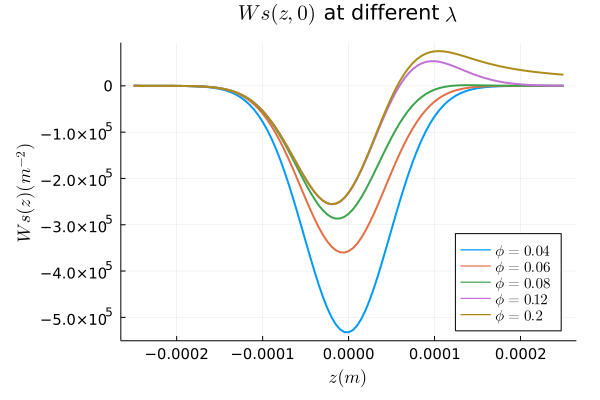

In [31]:
z_ob = range(-5*sigma_z, 5*sigma_z, length = 101)
#plot(z_ob, Ws_caseD_mat_lamb_0001[1:101], linewidth=2, label=L"\lambda \rho=0.001")
plot(z_ob, WsB_int_vec_1, linewidth=2, label=L"\phi=0.04")
plot!(z_ob, WsB_int_vec_2, linewidth=2, label=L"\phi=0.06")
plot!(z_ob, WsB_int_vec_3, linewidth=2, label=L"\phi=0.08")
plot!(z_ob, WsB_int_vec_4, linewidth=2, label=L"\phi=0.12")
plot!(z_ob, WsB_int_vec_5, linewidth=2, label=L"\phi=0.2")
#plot!(z_ob, WsB_int_vec_6, linewidth=2, label=L"\phi=0.6")
#plot!(z_ob, Ws_caseB_mat_phi_004[102:202], label=L"\phi=0.04", markersize = 4, seriestype = :scatter)
#plot!(z_ob, Ws_caseB_mat_phi_006[102:202], label=L"\phi=0.06", markersize = 4, seriestype = :scatter)
#plot!(z_ob, Ws_caseB_mat_phi_008[102:202], label=L"\phi=0.08", markersize = 4, seriestype = :scatter)
#plot!(z_ob, Ws_caseB_mat_phi_01[102:202], label=L"\phi=0.1", markersize = 4, seriestype = :scatter)
#plot!(z_ob, Ws_caseB_mat_phi_02[102:202], label=L"\phi=0.2", markersize = 4, seriestype = :scatter)
#plot!(z_ob, Ws_caseB_mat_phi_05[102:202], label=L"\phi=0.5", markersize = 4, seriestype = :scatter)
#plot!(z_ob, Ws_caseB_mat_phi_09[102:202], label=L"\phi=0.9", markersize = 4, seriestype = :scatter)

plot!(xlabel=L"$z (m)", ylabel=L"$Ws(z) (m^{-2})$", title=L"$Ws(z,0)$ at different $\lambda$")
plot!(xtickfont=font(10), ytickfont=font(10), guidefont=font(12), margin=4Plots.mm, legend=:bottomright, legendfontsize = 10)

In [59]:
lamb_vec = [0.01, 0.02, 0.03, 0.05, 0.08];
lamb_temp = lamb_vec[1]
WsD_1D_vec_1 = map(WsD_1D, z_ob);
lamb_temp = lamb_vec[2]
WsD_1D_vec_2 = map(WsD_1D, z_ob);
lamb_temp = lamb_vec[3]
WsD_1D_vec_3 = map(WsD_1D, z_ob);
lamb_temp = lamb_vec[4]
WsD_1D_vec_4 = map(WsD_1D, z_ob);
lamb_temp = lamb_vec[5]
WsD_1D_vec_5 = map(WsD_1D, z_ob);

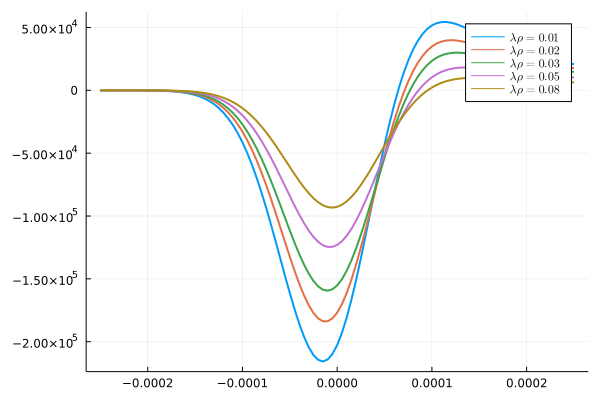

In [60]:
z_ob = range(-5*sigma_z, 5*sigma_z, length = 101)
plot(z_ob, WsD_1D_vec_1, linewidth=2, label=L"\lambda \rho=0.01")
plot!(z_ob, WsD_1D_vec_2, linewidth=2, label=L"\lambda \rho=0.02")
plot!(z_ob, WsD_1D_vec_3, linewidth=2, label=L"\lambda \rho=0.03")
plot!(z_ob, WsD_1D_vec_4, linewidth=2, label=L"\lambda \rho=0.05")
plot!(z_ob, WsD_1D_vec_5, linewidth=2, label=L"\lambda \rho=0.08")

# Profiling

In [28]:
using Profile
using Juno

In [31]:
@bprofile compute_Ws(0.0, 0.0, gamma, lamb, 101)

BenchmarkTools.Trial: 37 samples with 1 evaluation.
 Range (min … max):  127.897 ms … 171.893 ms  ┊ GC (min … max): 0.00% … 22.49%
 Time  (median):     133.068 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   138.315 ms ±  13.516 ms  ┊ GC (mean ± σ):  4.62% ±  8.78%

   ▃    █▃                                                       
  ▇█▇▇▄▄██▇▇▇▁▄▄▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▇▁▁▄▁▁▁▁▇ ▁
  128 ms           Histogram: frequency by time          172 ms <

 Memory estimate: 14.93 MiB, allocs estimate: 978587.

In [29]:
Profile.clear()

In [32]:
Juno.profiler()

false

In [13]:
#Profile.print()